## GAM link NN

Knots shape (11,)
Knots shape (13,)
Knots shape (15,)
Knots shape (17,)


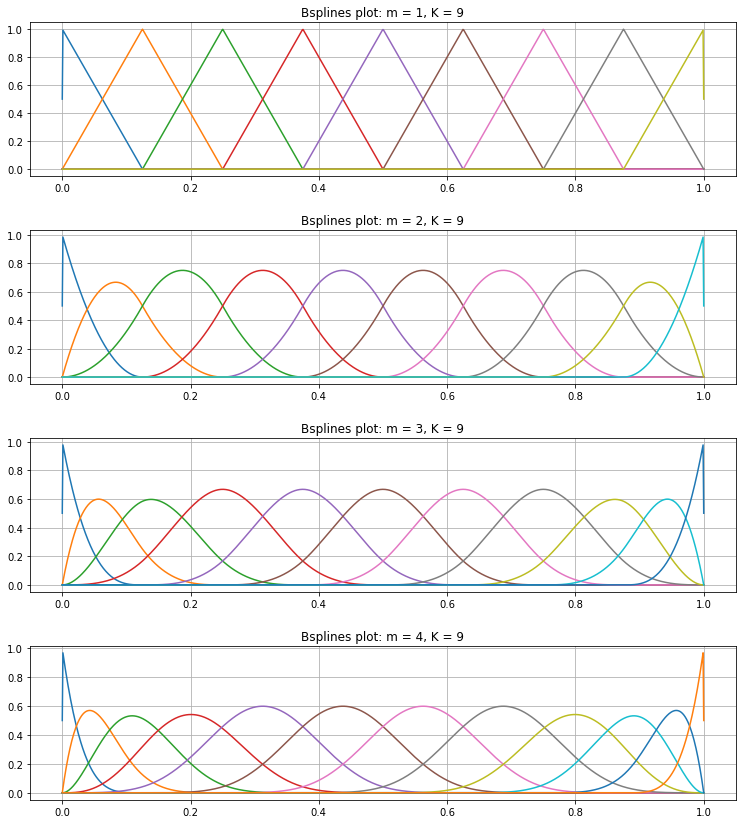

In [1]:
import lasagne
import theano
import numpy as np
from lasagne.layers import *
import theano.tensor as T
from itertools import *
import tqdm
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

%run gamnet_lib.ipynb

In [2]:
path_to_storage = 'D:/Datasets/Diploma/datasets/'

In [3]:
dataset = pd.read_csv(path_to_storage + 'meuse.csv').dropna()

In [4]:
dataset[['x', 'y', 'elev', 'dist.m', 'cadmium']].head(10)

,x,y,elev,dist.m,cadmium
0,181072,333611,7.909,50,11.7
1,181025,333558,6.983,30,8.6
2,181165,333537,7.800,150,6.5
3,181298,333484,7.655,270,2.6
4,181307,333330,7.480,380,2.8
5,181390,333260,7.791,470,3.0
6,181165,333370,8.217,240,3.2
7,181027,333363,8.490,120,2.8
8,181060,333231,8.668,240,2.4
9,181232,333168,9.049,420,1.6


In [5]:
dataset.shape

(161, 17)

In [6]:
X = np.array(dataset[['x', 'y', 'elev', 'dist.m']])
y = np.array(dataset['cadmium'])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [8]:
X_train, X_test = X_train.copy(), X_test.copy()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [12]:
from sklearn.model_selection import cross_val_score

In [22]:
#save_csv(X_train, y_train, 'train')
#save_csv(X_test, y_test, 'test')

### Scaled Gamnet penulized

In [231]:
input_matrix = T.matrix(name='features matrix', dtype='float32')
input_shape = (None, X_train.shape[1])
target_y = T.vector(name='target vector')
link_domain_var = T.matrix('link domain')
link_sides_var = T.matrix('link sides')

In [232]:
LINK_POLYGON = (0., 1.)
SPL_NB_KNOTS = 6
LINK_NB_KNOTS = 6
DOMAIN_NB_KNOTS = 10000
lamb = 1e-15

link_domain = np.linspace(0., 1, DOMAIN_NB_KNOTS).reshape(-1, 1)
print(link_domain.shape)


link_sides = np.array([[0.], [1.]])
print(link_sides.shape)

(10000, 1)
(2, 1)


In [400]:
gamnet = {}
gamnet['input'] = InputLayer(input_shape, input_var=input_matrix)
gamnet['bspl_1'] = BsplineLayer(gamnet['input'], nb_knots=SPL_NB_KNOTS, polygon=(0., 1.), order=3) 
gamnet['rsh_1'] = ReshapeLayer(gamnet['bspl_1'], (-1, input_shape[1] * gamnet['bspl_1'].output_shape[-1]))
gamnet['gam_inner'] = DenseLayer(gamnet['rsh_1'], num_units=1,\
                                            nonlinearity=lasagne.nonlinearities.linear)#,\
#                     
gamnet['scaler'] = MinMaxScalerLayer(gamnet['gam_inner'])
gamnet['bspl_link'] = BsplineLayer(gamnet['scaler'], polygon=LINK_POLYGON, nb_knots=LINK_NB_KNOTS, order=3)
gamnet['rsh_link'] = ReshapeLayer(gamnet['bspl_link'], (-1, gamnet['bspl_link'].output_shape[-1]))
gamnet['output'] = DenseLayer(gamnet['rsh_link'], num_units=1, nonlinearity=lasagne.nonlinearities.linear)

In [401]:
"""
gamnet = {}
gamnet['input'] = InputLayer(input_shape, input_var=input_matrix)
gamnet['fc_1'] = batch_norm(DenseLayer(gamnet['input'], num_units=256, nonlinearity=None))
#gamnet['dp_1'] = DropoutLayer(gamnet['fc_1'], p =0.5)

gamnet['fc_2'] = batch_norm(DenseLayer(gamnet['fc_1'], num_units=2566, nonlinearity=None))
gamnet['gam_inner'] = batch_norm(DenseLayer(gamnet['fc_2'], num_units=1))
# link
gamnet['scaler'] = MinMaxScalerLayer(gamnet['gam_inner'])
gamnet['bspl_link'] = BsplineLayer(gamnet['scaler'], polygon=LINK_POLYGON, nb_knots=LINK_NB_KNOTS)
gamnet['rsh_link'] = ReshapeLayer(gamnet['bspl_link'], (-1, gamnet['bspl_link'].output_shape[-1]))
gamnet['output'] = DenseLayer(gamnet['rsh_link'], num_units=1, nonlinearity=lasagne.nonlinearities.linear)
"""

"\ngamnet = {}\ngamnet['input'] = InputLayer(input_shape, input_var=input_matrix)\ngamnet['fc_1'] = batch_norm(DenseLayer(gamnet['input'], num_units=256, nonlinearity=None))\n#gamnet['dp_1'] = DropoutLayer(gamnet['fc_1'], p =0.5)\n\ngamnet['fc_2'] = batch_norm(DenseLayer(gamnet['fc_1'], num_units=2566, nonlinearity=None))\ngamnet['gam_inner'] = batch_norm(DenseLayer(gamnet['fc_2'], num_units=1))\n# link\ngamnet['scaler'] = MinMaxScalerLayer(gamnet['gam_inner'])\ngamnet['bspl_link'] = BsplineLayer(gamnet['scaler'], polygon=LINK_POLYGON, nb_knots=LINK_NB_KNOTS)\ngamnet['rsh_link'] = ReshapeLayer(gamnet['bspl_link'], (-1, gamnet['bspl_link'].output_shape[-1]))\ngamnet['output'] = DenseLayer(gamnet['rsh_link'], num_units=1, nonlinearity=lasagne.nonlinearities.linear)\n"

In [402]:
gam_inner_fun = theano.function([input_matrix], get_output(gamnet['gam_inner']), allow_input_downcast=True)

def update_scaler(gamnet):

    train_inners = gam_inner_fun(X_train)
    gamnet['scaler'].update_scale(train_inners.min(axis=0), train_inners.max(axis=0))

Knots shape (12,)


In [403]:
update_scaler(gamnet)

In [404]:
weights = get_all_params(gamnet['output'], trainable=True,)
network_output = lasagne.layers.get_output(gamnet['output'])
det_network_output = lasagne.layers.get_output(gamnet['output'], deterministic=True)
link_in = get_output(gamnet['scaler'])

Knots shape (12,)
Knots shape (12,)
Knots shape (12,)
Knots shape (12,)
Knots shape (12,)


In [405]:
bspls_d = bsplines(link_domain_var, polygon=LINK_POLYGON, nb_knots=LINK_NB_KNOTS, derivative_order=1)
link_d = T.dot(T.stack(bspls_d.values(), axis=-1).reshape((-1, LINK_NB_KNOTS + 2)),\
    gamnet['output'].W)
non_monotonic_loss = -T.minimum(link_d, 0).sum()

Knots shape (12,)


In [406]:
gam_d_pen = 1./DOMAIN_NB_KNOTS * T.sqr(link_d[1:]).sum()

In [407]:
bspls_dd = bsplines(link_domain_var, polygon=LINK_POLYGON, nb_knots=LINK_NB_KNOTS, derivative_order=2)
link_dd = T.dot(T.stack(bspls_dd.values(), axis=-1).reshape((-1, LINK_NB_KNOTS + 2)),\
    gamnet['output'].W)
gam_dd_pen = 1./DOMAIN_NB_KNOTS * T.sqr(link_dd[1:]).sum()

Knots shape (12,)


In [408]:
bspls_sides_d = bsplines(link_sides_var, polygon=LINK_POLYGON, nb_knots=LINK_NB_KNOTS, derivative_order=1)
link_sides_d = T.dot(T.stack(bspls_sides_d.values(), axis=-1).reshape((-1, LINK_NB_KNOTS + 2)),\
    gamnet['output'].W)
gam_sides_pen = link_sides_d.sum()

Knots shape (12,)


In [409]:
learning_rate = T.scalar(name='learning_rate')

In [410]:
from lasagne.regularization import regularize_layer_params_weighted, l2
layers = {gamnet['gam_inner']: 0.5, gamnet['output']: 0.1}
l2_penalty = regularize_layer_params_weighted(layers, l2)

In [411]:
mse_err =  lasagne.objectives.squared_error(network_output, target_y).mean() 
det_mse_err =  lasagne.objectives.squared_error(det_network_output, target_y).mean() 
loss = mse_err + 0.1 * non_monotonic_loss #+ l2_penalty
loss +=  lamb * (gam_d_pen + gam_dd_pen + gam_sides_pen)
updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=learning_rate)

In [412]:
#training

train = theano.function([input_matrix, target_y, link_domain_var, link_sides_var, learning_rate], [mse_err, loss], updates=updates, allow_input_downcast=True)
#train = theano.function([input_matrix, target_y, link_domain_var, learning_rate], [mse_err, loss],\
#                        updates=updates, allow_input_downcast=True)


In [413]:
loss_fun = theano.function([input_matrix, target_y, link_domain_var, link_sides_var], [mse_err, loss],  allow_input_downcast=True)
#loss_fun = theano.function([input_matrix, target_y, link_domain_var],\
#                           [det_mse_err, loss],  allow_input_downcast=True)

In [414]:
gam_inner_sacled_fun = theano.function([input_matrix], get_output(gamnet['scaler']), allow_input_downcast=True)

def visualize_link(gamnet):        
    train_inners = gam_inner_sacled_fun(X_train).ravel()
    plt.figure()
    plt.grid()
    plt.title('Link func')
    plt.plot(train_inners, predict(X_train).ravel(), 'o')   
    plt.show()
    return train_inners, predict(X_train).ravel()

Knots shape (12,)


In [415]:
predict = theano.function([input_matrix], network_output, allow_input_downcast=True)

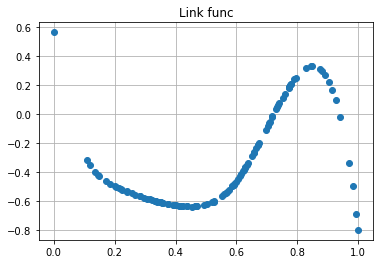

In [416]:
links_track = {}
links_track[0] = visualize_link(gamnet)

In [417]:
args = np.linspace(0., 1., 1000)
def visualize_m(gamnet):
    x = T.vector()
    bspl = bsplines(x, polygon=(0.,1.), nb_knots=SPL_NB_KNOTS, order=3, derivative_order=0)
    bspl_func = [theano.function([x], bspl_v) for bspl_v in bspl.values()]
    w_par = gamnet['gam_inner'].W.get_value()
    cell = int(w_par.shape[0] / 4)
    w_wise = w_par.reshape(4, -1)
    return np.dot(w_wise, np.vstack([bspl_func[j](args) for j in range(cell)]))

In [418]:
args.shape

(1000,)

In [419]:
'''
n_row = 4
n_col = 1
plt.figure(figsize=(10 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
orders = [1, 2, 3, 4]
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    order = orders[i]
    x = T.vector()
    bspl = bsplines(x, polygon=(0.,1.), nb_knots=9, order=order, derivative_order=0)
    bspl_func = [theano.function([x], bspl_v) for bspl_v in bspl.values()]
    #plt.figure(figsize=(12, 3))
    plt.title('Bsplines plot: m = {}, K = {}'.format(order, 9))
    plt.grid()
    for j in range(len(bspl_func)):
        plt.plot(np.linspace(0, 1, 1000), bspl_func[j](np.linspace(0, 1, 1000)))
'''

"\nn_row = 4\nn_col = 1\nplt.figure(figsize=(10 * n_col, 3 * n_row))\nplt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)\norders = [1, 2, 3, 4]\nfor i in range(n_row * n_col):\n    plt.subplot(n_row, n_col, i + 1)\n    order = orders[i]\n    x = T.vector()\n    bspl = bsplines(x, polygon=(0.,1.), nb_knots=9, order=order, derivative_order=0)\n    bspl_func = [theano.function([x], bspl_v) for bspl_v in bspl.values()]\n    #plt.figure(figsize=(12, 3))\n    plt.title('Bsplines plot: m = {}, K = {}'.format(order, 9))\n    plt.grid()\n    for j in range(len(bspl_func)):\n        plt.plot(np.linspace(0, 1, 1000), bspl_func[j](np.linspace(0, 1, 1000)))\n"

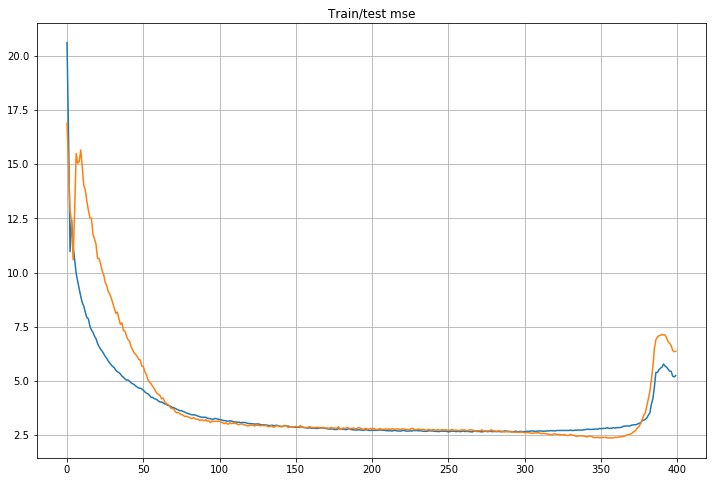

Epoch 400 of 400 took 0.187s
  training mse (in-iteration):		5.249010
  training loss (in-iteration):		5.249101
  test mse:		6.37


In [420]:
import time
from IPython import display

num_epochs = 400 #amount of passes through the data
batch_size = 4 #number of samples processed at each function call (32)
mse_track_train = []
mse_track_test = []
links_track = {}
ms_track = {}

#lr = 0.1
lr = 0.001

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_loss = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchsize=batch_size, shuffle=True):
        inputs, targets = batch
        train_mse_err_batch, train_loss_batch= train(inputs, targets, link_domain, link_sides,  lr)
        #train_mse_err_batch, train_loss_batch= train(inputs, targets, link_domain, lr)

        update_scaler(gamnet)#
        train_err += train_mse_err_batch
        train_loss += train_loss_batch
        train_batches += 1
           
    # And a full pass over the validation data:
    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batchsize=batch_size, shuffle=False):
        inputs, targets = batch
        
        test_mse_err, test_loss = loss_fun(inputs, targets, link_domain, link_sides)
#       test_mse_err, test_loss = loss_fun(inputs, targets, link_domain)
        test_err+=test_mse_err
        test_batches += 1

    mse_track_train.append(train_err / train_batches)
    mse_track_test.append(test_err / test_batches)
    
    display.clear_output(wait=True)

    
    if epoch % 20 == 0 or epoch == 0 or epoch == 9:
        links_track[epoch] = visualize_link(gamnet) 
        ms_track[epoch] = visualize_m(gamnet) 
        
    plt.figure(figsize=(12, 8))
    plt.grid()
    plt.plot(mse_track_train)
    plt.plot(mse_track_test)
    plt.title('Train/test mse')
    plt.show()
    
    if test_err / test_batches < 0.45:
        break
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training mse (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_loss / train_batches))
    print("  test mse:\t\t{:.2f}".format(
        test_err / test_batches))

In [421]:
#loss_tracks = {}

In [429]:
#loss_tracks['nesterov_momentum'] = mse_track_train

['sgd', 'adam', 'nesterov_momentum', 'rmsprop']

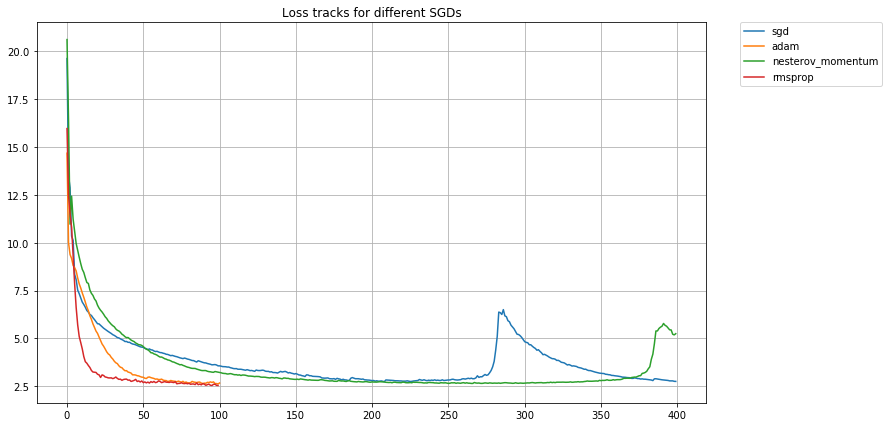

In [437]:
plt.figure(figsize=(12,7))
plt.grid()
for k in ['sgd', 'adam', 'nesterov_momentum', 'rmsprop']:
    plt.plot(loss_tracks[k], label=k)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Loss tracks for different SGDs')

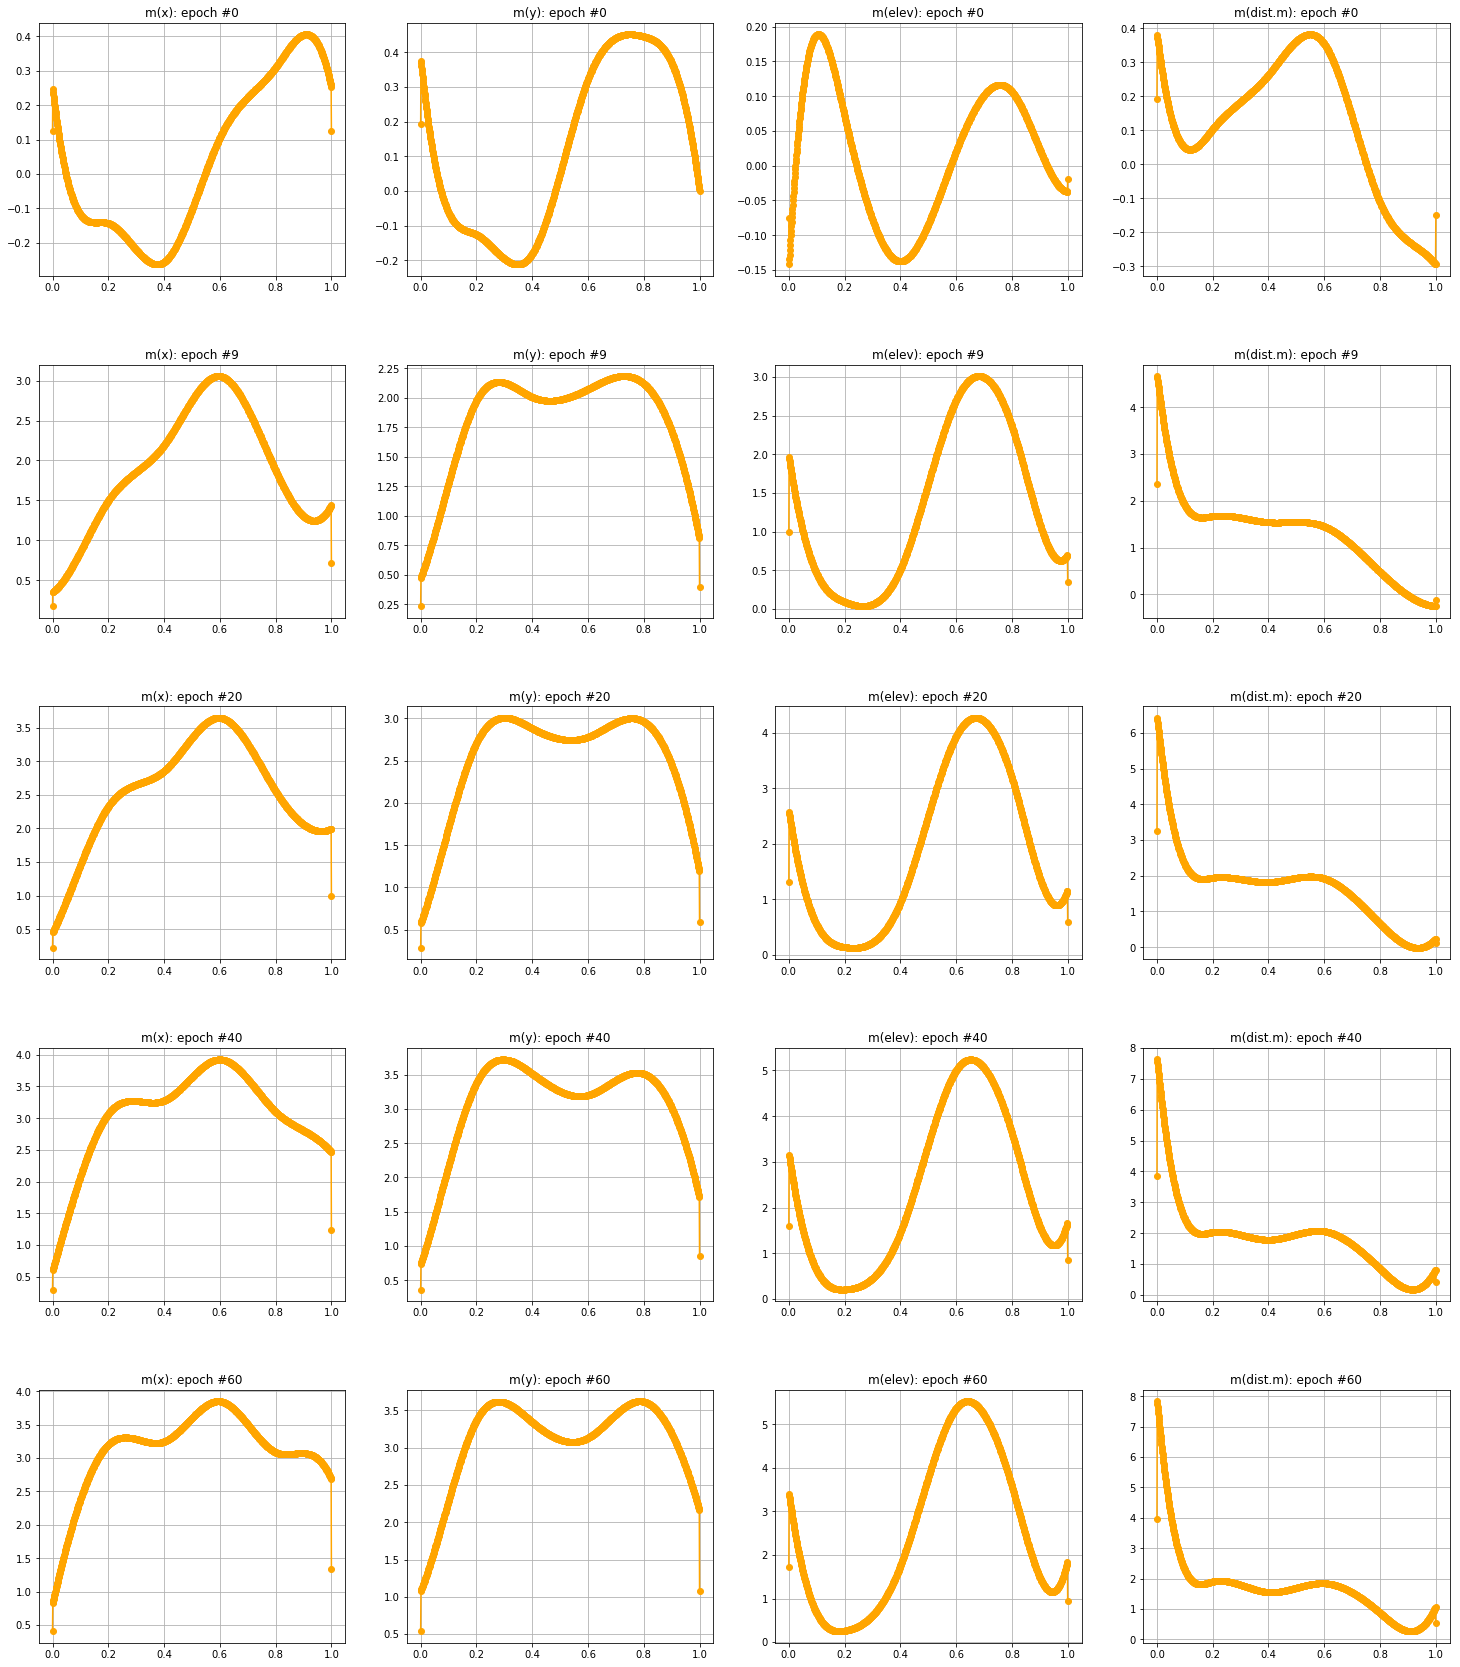

In [423]:

n_row = 5
n_col = 4
plt.figure(figsize=(5 * n_col, 5 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(n_row):
    m_is = ms_track[list(ms_track.keys())[i]]
    for k in range(n_col):
        plt.subplot(n_row, n_col, i*n_col + k + 1)
        yp = m_is[k]
        plt.grid()
        cols = ['x', 'y', 'elev', 'dist.m']
        plt.title('m({}): epoch #{}'.format(cols[k], list(ms_track.keys())[i]))
        plt.plot(args, yp, 'o-', color='orange')


In [424]:
'''
n_row = 3
n_col = 3
plt.figure(figsize=(5 * n_col, 5 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    xp, yp = links_track[i]
    plt.grid()
    plt.title('{} epoch: link function plot'.format(i))
    plt.plot(sorted(xp), yp[xp.argsort()], 'o-')
'''

"\nn_row = 3\nn_col = 3\nplt.figure(figsize=(5 * n_col, 5 * n_row))\nplt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)\nfor i in range(n_row * n_col):\n    plt.subplot(n_row, n_col, i + 1)\n    xp, yp = links_track[i]\n    plt.grid()\n    plt.title('{} epoch: link function plot'.format(i))\n    plt.plot(sorted(xp), yp[xp.argsort()], 'o-')\n"

In [425]:
preds = predict(X_test)

In [426]:
#preds2 = predict(X_test)

In [427]:
#preds3 = predict(X_test)

In [428]:
#preds4 = predict(X_test)

In [ ]:
preds5 = predict(X_test)

In [ ]:
mean_squared_error((preds1+preds2+preds3+preds4)/4, y_test)

In [ ]:
"""
Epoch 320 of 400 took 1.628s
training mse (in-iteration):		144.607658
training loss (in-iteration):		144.607660
test mse:		119.76
"""

In [ ]:
"""

Epoch 94 of 400 took 12.532s
  training mse (in-iteration):		105.644490
  training loss (in-iteration):		105.644559
  test mse:		118.39
"""

In [ ]:
"""
  training loss (in-iteration):		143.534287
  test mse:		119.27
In [ ]:

"""